# DBSCAN ALGORITHM

- https://scikit-learn.org/1.5/auto_examples/cluster/plot_dbscan.html
- https://scikit-learn.org/dev/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN


It is a density-based clustering algorithm, which works with the distance between pairs of points. It recibes two parameters, **min_points** and **$\epsilon$**, and the number of clusters does not need to be spicified before applying the algorithm

It works as follows:

1. Computes the distances between each pair of points

    
2. For each point (let's say, "P") it computes how many neighbors it has. How? Using the parameter **$\epsilon$** as the maximum distance to consider two points as neigbhours. Considering another point "Q", if dist(P,Q) < $\epsilon$, then they are neighbors.


3. The algorithm recibes another parameter called **min_points**, which is the minimum number of points, neighbors to "P", to consider "P" as a "core" element (high-density sample)


4. The clusters are formed iterating over all points, and considering the neighbours points that are core-elements (for example if both "P" and "Q" are core elements and neighbors). 


5. If another point, let's say "M", is not a core-point but it is neighbour of "P" can be connected through a chain of core-points (for example, going from "P" to "M" trough "Q"), then "M" is also considered as part of the cluster (border). 


6. The rest of the points, which are neither border of the cluster or core-points, are considered noise. 


<br>

The algorithm is very sensitive to the coiche of both parameters, specially the threshold $\epsilon$. To determinate the optimal value of $\epsilon$, it is useful to use a **k-distance plot**. The idea is to calculate, the average of the distances of every point to its k-nearest neighbors. The value of **k** will be specified by the user and corresponds to the chose parameter for **min_points**. Next, these k-distances are plotted in ascending order. The aim is to determine the "knee", which corresponds to the optimal epsilon parameter. A knee corresponds to a threshold where a sharp change occurs along the k-distance curve.


- https://scikit-learn.org/dev/modules/neighbors.html#unsupervised-neighbors

- https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.NearestNeighbors.html


<br>

For the paramater **min_points** it is very often to use 4 with 2-D datasets (min_points = 2·D for a data-set wth D dimensions)


- https://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/


- Ester, M., Kriegel, H. P., Sander, J., & Xu, X. (1996, August). A density-based algorithm for discovering clusters in large spatial databases with noise. In kdd (Vol. 96, No. 34, pp. 226-231).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneebow.rotor import Rotor
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, LineString, Polygon


def map_network(lat1,lon1,lat2,lon2,lat3,lon3,lat4,lon4):
    """" Function that creates a map of the urban network from a polygon (given the 4 bounds).
    
    Input:
        - bounds: 4 latitude and longitude points (GPS coordinates)
        
    Output:
        - The figure and the axes.
        
    """
    
    P = Polygon([(lat1,lon1), (lat2,lon2),(lat3,lon3),(lat4,lon4)])  # Create the graph from lat and lon bounds
    G = ox.graph_from_polygon(P, network_type='all') 
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="w",edge_color="#333333", edge_linewidth=1, node_size=0)
    place_name = "Granollers, Vallès Oriental"
    tags={"building": True}
    gdf = ox.geometries_from_place(place_name, tags)
    gdf.shape
    gdf.plot(ax=ax,color='silver',alpha=0.7)
    buildings = ox.geometries_from_place(place_name, tags={'building':True}) # Retrieve buildings from the area:
    
    #for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():     # Name of the street
        #c = edge['geometry'].centroid
        #text = edge['name']
        #ax.annotate(text, (c.x, c.y), c='w')       
 
    return fig, ax


def buffer_in_meters(lng, lat, radius):
    'Given the gps coordenates and the desired radius (in metres), the function creates a circle around the gps point'
    from functools import partial
    import pyproj
    from shapely.geometry import Point
    from shapely.ops import transform
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
    pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    
    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng



## Read the data-set with the stops

The data-set with the stops. The 7 columns are :

1. accio --> The code of the activity performed at the stop
2. color --> The color identifying the action/stop
3. latitude --> Latitude of the stop in degrees
4. longitude --> Longitude of the stop in degrees
5. durada --> Duration of the stop, in seconds
5. lat utm --> Latitude of the stop, projected in a 2-d plane with the UTM projection
6. lon utm --> Longitude of the stop, projected in a 2-d plane with the UTM projection

In [3]:
df_stops = pd.read_csv('stops_granollers.csv')
df_stops

,accio,color,latitud,longitud,durada,lat utm,lon utm
0,Ce1+CCe1+Me1,seagreen,41.604203,2.282094,985.0,440177.563298,4.606082e+06
1,Xe1,darkblue,41.603524,2.281836,521.0,440155.409060,4.606007e+06
2,Je1,m,41.603248,2.281657,100.0,440140.237344,4.605976e+06
3,Je1,m,41.603673,2.281787,249.0,440151.435778,4.606023e+06
4,Be1,red,41.603620,2.281892,151.0,440160.164268,4.606017e+06
...,...,...,...,...,...,...,...
63,Bg7+Cg7+Xg7+Jg7+Mg7,red,41.603630,2.282209,3130.0,440186.578644,4.606018e+06
64,Cg8+CCg8+Mg8,seagreen,41.602827,2.281688,656.0,440142.404194,4.605929e+06
65,Bg8,red,41.603659,2.282345,918.0,440197.948941,4.606021e+06
66,Jg8,m,41.603631,2.282223,713.0,440187.715579,4.606018e+06


## Computing the optimal value of $\epsilon$

In [4]:
def average_kn_distance(X, neigh, metric):
    ''' Function that computes and returns the average distance of the k-nearest neighbors of each point of a data-set.
        
        Inputs:  
            - X --> array (matrix) of data points
            - neigh --> number of k-nearest neighbors, which is neigh = min_data in DBSCAN Algorithm
            - metric --> metric to be used for the calculation of distances
            
        Outputs: 
            - Mean distance of the k-nearest neighbors for each data points
    
    '''
    # Compute the matrix of distances (for each point, first value will be 0 because it is the distance with itself)
    neigh = NearestNeighbors(n_neighbors = neigh, metric = metric)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Compute the average distance, for each data-point
    avg_distances = np.mean(distances[:,1:],axis=1)
    
    return avg_distances



def get_eps(X, neigh, metric):
    ''' Function that computes and returns the "optimal" value of epsilon (mean average distance of the k-nearest neighbors).
        It is computed plotting a graph of the k-distances, with the sorted data points, and finding the elbow of the curve.
        
        With the library of "kneebow", which uses a Rotor to simply rotate the data, so that curve looks down and then take the 
        minimum value (elbow). https://github.com/georg-un/kneebow

        
        Inputs:  
            - X --> array (matrix) of data points
            - neigh --> number of k-nearest neighbors, which is neigh = min_data in DBSCAN Algorithm
            - metric --> metric to be used for the calculation of distances
            
        Outputs: 
            - The elbow of the curve (value of epsilon)
    
    '''
    # Compute and sort the avg distances of the k-nearest neighbors of each data point
    sorted_avg_distances = np.sort(average_kn_distance(X, neigh, metric))
    
    # To 2-D array (x = sorted index of data-points, y = sorted avg distances of k-nearest neighbors)
    curve_xy = np.concatenate([np.arange(sorted_avg_distances.shape[0]).reshape(-1,1), sorted_avg_distances.reshape(-1,1)],1)
    
    # Use the rotor to find the elbow
    rotor = Rotor()
    rotor.fit_rotate(curve_xy)
    
    # Plot
    plt.rcParams["figure.figsize"] = [10,8]

    rotor.plot_elbow()
    
    plt.xlabel('Index of points sorted by distance',fontsize = 15)
    plt.ylabel('k-NN distance', fontsize = 15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    
    e_idx = rotor.get_elbow_index()
    
    return curve_xy[e_idx]




###  Using latitude and longitude with Euclidean distances

We first have to transform latitude and longitude coordinates to UTM projection (2d-plane)

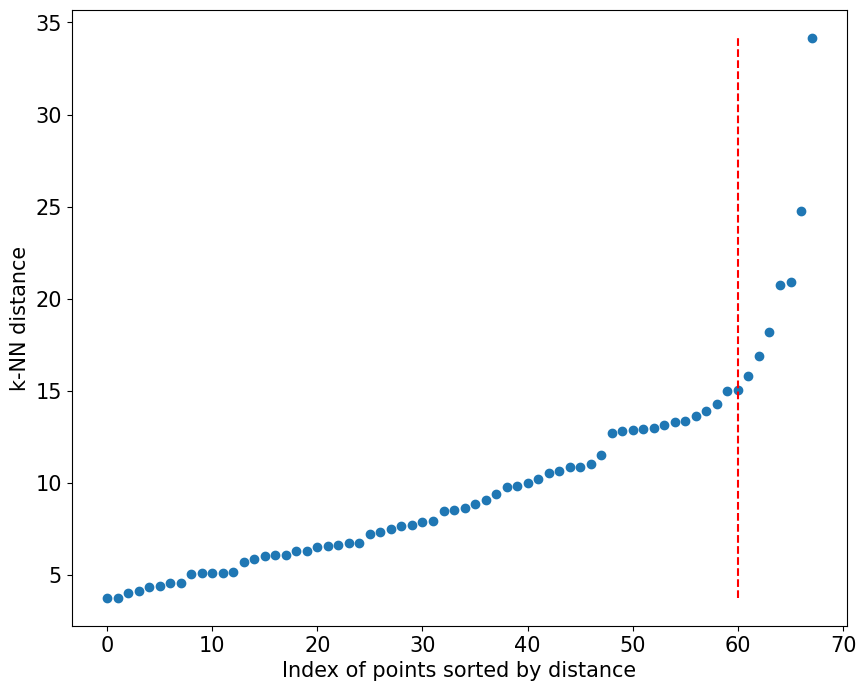

The elbow is located at point: 60, corresponding to an epsilon = 15.069422405157283


In [5]:
df_euclidean = pd.DataFrame()
df_euclidean['latitud'] = df_stops['latitud']
df_euclidean['longitud'] = df_stops['longitud']


coord_utm = df_stops[['lat utm', 'lon utm']].values
weights = df_stops['durada'].values



# Compute epsilon (and graph) using min_data = k-nearest = 4 (2-D) and the haversine distance between GPS coordinates
idx, eps = get_eps(X = coord_utm, neigh = 4, metric = 'euclidean')


plt.show()

print('The elbow is located at point: {}, corresponding to an epsilon = {}'.format(int(idx),eps))





## DBSCAN with eps=15min and min_samples = 4

Applying the algorithm and cluster representation on map

Estimated number of clusters: 5
Estimated number of noise points: 9


C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2

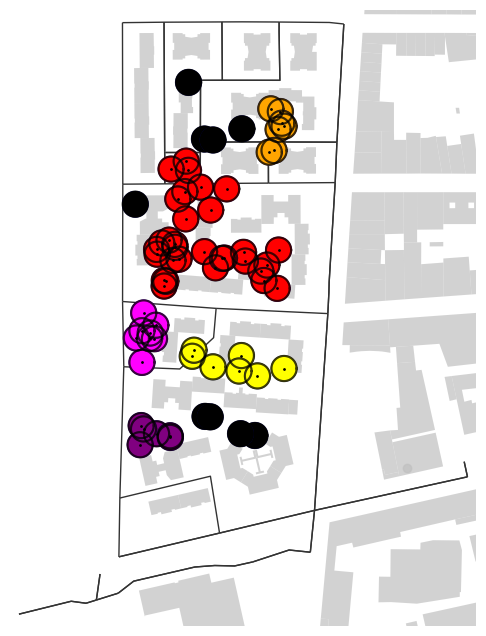

In [6]:
# Apply the DBSCAN Algorithm
clusters = DBSCAN(eps=eps, min_samples=4, algorithm='ball_tree', metric='euclidean').fit(coord_utm) 
labels = clusters.labels_

df_euclidean['labels'] = labels


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)



# PLOT

fig, ax = map_network(2.2804419490443517, 41.605107921345585, 2.28054397694062,41.60183248235341,  
                       2.283748215236327,41.602065783859004,  2.2840062702794897, 41.60530532450823)


for i in range(len(df_euclidean)):
    a_k6 = buffer_in_meters(df_euclidean['longitud'][i],df_euclidean['latitud'][i],9)
    x,y = a_k6.exterior.xy
    
    plt.fill(x,y,color='blue',alpha=1.)
    plt.plot(x,y,color='black',alpha=0.5)
    
    if df_euclidean['labels'][i]==-1:
        plt.fill(x,y,color='black',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if df_euclidean['labels'][i]==0:
        plt.fill(x,y,color='red',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)

    if df_euclidean['labels'][i]==1:
        plt.fill(x,y,color='magenta',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if df_euclidean['labels'][i]==2:
        plt.fill(x,y,color='purple',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if df_euclidean['labels'][i]==3:
        plt.fill(x,y,color='orange',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if df_euclidean['labels'][i]==4:
        plt.fill(x,y,color='yellow',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if df_euclidean['labels'][i]==5:
        plt.fill(x,y,color='orange',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)



ax.scatter(df_euclidean['longitud'], df_euclidean['latitud'], c='black', s=1,zorder=3)



plt.show()

### DBSCAN for different values of epsilon and min_points

In [30]:
epsilons = [10,12,15,18,20,25]

for epss in epsilons:
    df_euclidean2 = df_euclidean.copy()
    # Apply the DBSCAN Algorithm
    clusters = DBSCAN(eps=epss, min_samples=5, algorithm='ball_tree', metric='euclidean').fit(coord_utm) 
    labels = clusters.labels_

    df_euclidean2['labels'] = labels


    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print('eps:',epss)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print('---------------------------------------------------')
    print('')

eps: 10
Estimated number of clusters: 4
Estimated number of noise points: 43
---------------------------------------------------

eps: 12
Estimated number of clusters: 6
Estimated number of noise points: 24
---------------------------------------------------

eps: 15
Estimated number of clusters: 4
Estimated number of noise points: 16
---------------------------------------------------

eps: 18
Estimated number of clusters: 5
Estimated number of noise points: 10
---------------------------------------------------

eps: 20
Estimated number of clusters: 4
Estimated number of noise points: 8
---------------------------------------------------

eps: 25
Estimated number of clusters: 2
Estimated number of noise points: 2
---------------------------------------------------



In [23]:
df_euclidean2 = df_euclidean.copy()
# Apply the DBSCAN Algorithm
clusters = DBSCAN(eps=18, min_samples=2, algorithm='ball_tree', metric='euclidean').fit(coord_utm) 
labels = clusters.labels_

df_euclidean2['labels'] = labels


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

#print('eps:',epss)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print('---------------------------------------------------')
print('')

Estimated number of clusters: 7
Estimated number of noise points: 2
---------------------------------------------------



C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

C:\Users\josep\AppData\Roaming\Python\Python39\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\josep\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#ax

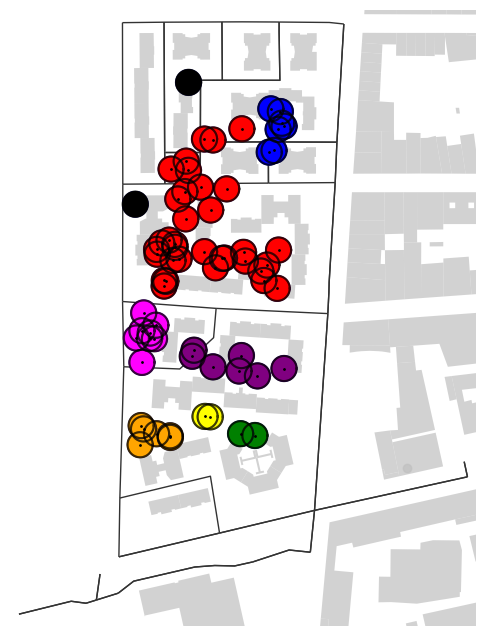

In [18]:
# PLOT

fig, ax = map_network(2.2804419490443517, 41.605107921345585, 2.28054397694062,41.60183248235341,  
                       2.283748215236327,41.602065783859004,  2.2840062702794897, 41.60530532450823)


for i in range(len(df_euclidean2)):
    a_k6 = buffer_in_meters(df_euclidean2['longitud'][i],df_euclidean2['latitud'][i],9)
    x,y = a_k6.exterior.xy
    
    plt.fill(x,y,color='blue',alpha=1.)
    plt.plot(x,y,color='black',alpha=0.5)
    
    if df_euclidean2['labels'][i]==-1:
        plt.fill(x,y,color='black',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if df_euclidean2['labels'][i]==0:
        plt.fill(x,y,color='red',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)

    if df_euclidean2['labels'][i]==1:
        plt.fill(x,y,color='magenta',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if df_euclidean2['labels'][i]==2:
        plt.fill(x,y,color='purple',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if df_euclidean2['labels'][i]==3:
        plt.fill(x,y,color='orange',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if df_euclidean2['labels'][i]==4:
        plt.fill(x,y,color='yellow',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)
        
    if df_euclidean2['labels'][i]==5:
        plt.fill(x,y,color='blue',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)

    if df_euclidean2['labels'][i]==6:
        plt.fill(x,y,color='green',alpha=1.)
        plt.plot(x,y,color='black',alpha=0.5)


ax.scatter(df_euclidean2['longitud'], df_euclidean2['latitud'], c='black', s=1,zorder=3)



plt.show()